# Simulation Plots

In [25]:
import numpy as np
import pandas as pd
import math

from datetime import datetime

from math import pi, sin, cos, radians, exp, sqrt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.signal import savgol_filter

from tqdm import tqdm
from pathlib import Path

tqdm.pandas()

# Plotting
from matplotlib import pyplot as plt, figure
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from plotly import express as px
import cartopy.crs as ccrs

In [26]:
# Set data frame options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Surface Roughness Simulation

In [27]:
def s_formula(inc_angle, sigma):
    elev_angle = 90-inc_angle
    return exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(elev_angle))**2)

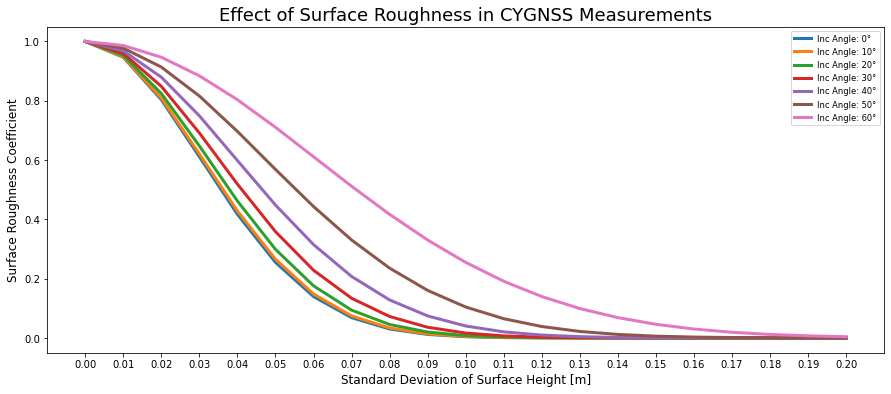

In [28]:
fig = plt.figure(figsize=(15, 6))
for angle in range(0, 61, 10):

    S = []
    sigmas = []

    for sig in range(0, 21, 1):
        S.append(s_formula(angle, sig/100))
        sigmas.append(sig/100)
    
    plt.plot(sigmas, S, linewidth=3.0, label='Inc Angle: ' + str(angle) + '°')
    plt.title('Effect of Surface Roughness in CYGNSS Measurements', fontsize=18)
    plt.ylabel('Surface Roughness Coefficient', fontsize=12)
    plt.xlabel('Standard Deviation of Surface Height [m]', fontsize=12)
    plt.xticks(np.arange(min(sigmas), max(sigmas) + 0.01, 0.01))

plt.legend(fontsize='small')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/SurfaceRoughnessSimulation.png', bbox_inches='tight')
plt.show()

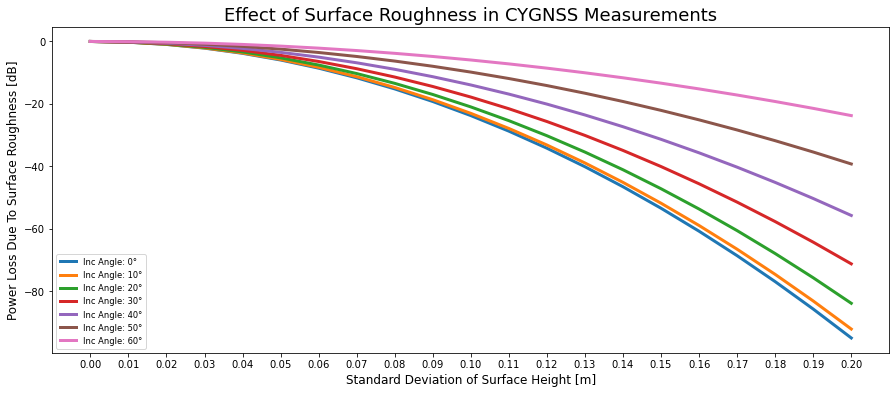

In [29]:
fig = plt.figure(figsize=(15, 6))
for angle in range(0, 61, 10):

    S = []
    sigmas = []

    for sig in range(0, 21, 1):
        S.append(10 * np.log10(s_formula(angle, sig/100)))
        sigmas.append(sig/100)
    
    plt.plot(sigmas, S, linewidth=3.0, label='Inc Angle: ' + str(angle) + '°')
    plt.title('Effect of Surface Roughness in CYGNSS Measurements', fontsize=18)
    plt.ylabel('Power Loss Due To Surface Roughness [dB]', fontsize=12)
    plt.xlabel('Standard Deviation of Surface Height [m]', fontsize=12)
    plt.xticks(np.arange(min(sigmas), max(sigmas) + 0.01, 0.01))

plt.legend(fontsize='small')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/SurfaceRoughnessSimulationDB.png', bbox_inches='tight')
plt.show()

### Fresnel Coefficient (LHCP) Simulation

In [30]:
# Permittivity Air
perm_air = 1

# Permittivity Soil
perm_dry = 3
perm_wet = 15
perm_saturated = 30

In [31]:
def r_para_formula(inc_angle, permittivity=perm_dry):
    above = permittivity * sin(radians(90-inc_angle)) - sqrt(perm_air * permittivity - (perm_air * cos(radians(90-inc_angle)))**2)
    below = permittivity * sin(radians(90-inc_angle)) + sqrt(perm_air * permittivity - (perm_air * cos(radians(90-inc_angle)))**2)
    return above / below


def r_perp_formula(inc_angle, permittivity=perm_dry):
    above = perm_air * sin(radians(90-inc_angle)) - sqrt(perm_air * permittivity - (perm_air * cos(radians(90-inc_angle)))**2)
    below = perm_air * sin(radians(90-inc_angle)) + sqrt(perm_air * permittivity - (perm_air * cos(radians(90-inc_angle)))**2)
    return above / below


def fresnel_cross_formula(r_para, r_perp):
    return 0.5 * (r_para - r_perp)


/Users/madsrindal/opt/miniconda3/envs/SemesterProject/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


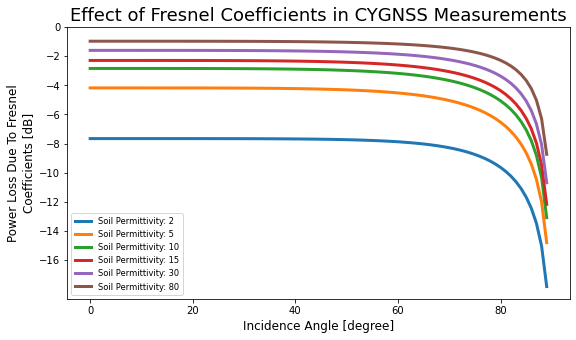

In [32]:
soil_types = [2, 5, 10, 15, 30, 80]

fig = plt.figure(figsize=(9, 5))
for soil_type in soil_types:
    r_values = []
    angles = []
    
    for angle in range(0, 91, 1):
        r_para = r_para_formula(angle, soil_type)
        r_perp = r_perp_formula(angle, soil_type)
        
        r_values.append(10 * np.log10(fresnel_cross_formula(r_para, r_perp)))
        angles.append(angle)

    plt.plot(angles, r_values, linewidth=3.0, label='Soil Permittivity: ' + str(soil_type))
    plt.title('Effect of Fresnel Coefficients in CYGNSS Measurements', fontsize=18)
    plt.ylabel('Power Loss Due To Fresnel\nCoefficients [dB]', fontsize=12)
    plt.xlabel('Incidence Angle [degree]', fontsize=12)
    plt.xticks(np.arange(min(angles), max(angles), 20))
    plt.yticks(np.arange(-16, 1, 2))

plt.legend(fontsize='small')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/FresnelCoefficientSimulationDB.png', bbox_inches='tight')
plt.show()

# Choosing Incidence Angle Interval

### Initial Minimization function

In [ ]:
def cost_function(X):
    start_inc_angle = min(X)
    end_inc_angle = max(X)
    mid_inc_angle = int((start_inc_angle + end_inc_angle) / 2)
    
    #print('start_inc_angle: ', start_inc_angle)
    #print('end_inc_angle: ', end_inc_angle)
    #print('mid_inc_angle: ', mid_inc_angle)
    
    
    # --------------------------------------------- S-VALUE -------------------------------------------
    def S_coeff(sigma):
        return exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(90-mid_inc_angle))**2)

    S = quad(S_coeff, 0, 0.2)[0]
    #print('S: ', S)
    
    
    # ------------------------------------- Power Loss Value ------------------------------------------
    pl_start_inc = 10 * np.log10(s_formula(start_inc_angle, 0.15))
    pl_end_inc = 10 * np.log10(s_formula(end_inc_angle, 0.15))
    uncertainty = abs(pl_start_inc - pl_end_inc)
    
    #print('Power loss at lowest IA: ', pl_start_inc)
    #print('Power loss at highest IA: ', pl_end_inc)
    #print('Uncertainty: ', uncertainty)
    
    
    # ------------------------------------- Observations Value -----------------------------------------
    n_obs = filter_inc_angle(cygnss_df, start_inc_angle, end_inc_angle).shape[0]
    days = len(filter_inc_angle(cygnss_df, start_inc_angle, end_inc_angle)['day_of_year'].unique())*years_of_data
    
    if n_obs == 0:
        return math.inf
    else:
        n_avg = n_obs / days
    #print('Average Number of Observastions per Day: ', n_avg)
    
    
    # ------------------------------------- F Value -----------------------------------------
    F = uncertainty / (S * n_avg)
    return F
    

In [ ]:
def minimization_function(cost_func, initial_guess):
    # Initial guess
    x_0 = [initial_guess[0], initial_guess[1]]
    
    # Bounds
    bnds = ((0, 59), (1, 60))

    # Constraints
    cons = ({'type':'ineq', 'fun': lambda x_0: (-x_0[1] + 61)}, 
            {'type':'ineq', 'fun': lambda x_0: (x_0[0] - x_0[1] + 10)},
            {'type':'ineq', 'fun': lambda x_0: (x_0[1] - x_0[0] - 5)}) 

    res = minimize(cost_func, x_0, constraints=cons, bounds=bnds)
    
    if not (res.success):
        return res.x, math.inf
    
    return res.x, res.fun

### Helping Functions

In [33]:
def store_df_as_csv(df, storage_path, file_name):
    storage_dir = Path(storage_path)
    storage_dir.mkdir(parents=True, exist_ok=True)
    df.to_csv(storage_dir / file_name, index=False)
    

def filter_inc_angle(df, min_angle, max_angle):
    filtered_df = df[df.sp_inc_angle <= max_angle]
    filtered_df = filtered_df[filtered_df.sp_inc_angle >= min_angle]
    return filtered_df


def generate_qf_list(qf_number):
    qf_list = []
    binary = format(qf_number, 'b')
    for i in range(len(binary)):
        if binary[i] == '1':
            qf_list.append(2 ** (int(i)))

    return qf_list


def filter_quality_flags_1(df):
    df['qf_ok'] = df.apply(
        lambda row: (2 or 4 or 5 or 8 or 16 or 17) not in generate_qf_list(int(row.quality_flags)), axis=1)
    df = df[df['qf_ok']]
    return df


def filter_cygnss_qf(df):
    remove_mask = int('11000000010011010', 2)

    return df[df['quality_flags'] & remove_mask == 0]


def get_month_from_doy(dayOfYear, year):
    return datetime.strptime('{} {}'.format(dayOfYear, year),'%j %Y').month


def filter_location(df, location):
    filtered_df = df[df.sp_lat < location[0]]
    filtered_df = filtered_df[filtered_df.sp_lat > location[2]]
    filtered_df = filtered_df[filtered_df.sp_lon < location[3]]
    filtered_df = filtered_df[filtered_df.sp_lon > location[1]]
    return filtered_df


def scale_sr_values(df):
    min_sr = df['sr'].min()
    df['sr'] = df['sr'].apply(lambda x: x - min_sr)
    return df


def get_pl_from_inc_angle(df, inc_angle, inc_range):   
    angles = []
    sd_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        df = df[df['inc_range'] == inc_range]
        sd_values = list(df['sr_sd'][df['inc_start'] == x_0])
        sd_median = np.median(sd_values)
        
        angles.append(x_0)
        sd_median_values.append(sd_median)
    
    return sd_median_values[inc_angle]


def get_pl_smooth_from_inc_angle(df, inc_angle, inc_range):
    angles = []
    sd_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        df = df[df['inc_range'] == inc_range]
        sd_values = list(df['sr_sd'][df['inc_start'] == x_0])
        sd_median = np.median(sd_values)
        
        angles.append(x_0)
        sd_median_values.append(sd_median)
    
    sd_median_smooth = savgol_filter(sd_median_values, 13, 3)
    
    return sd_median_smooth[inc_angle]


def get_n_median_from_inc_angle(df, inc_angle, inc_range):
    angles = []
    n_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        df = df[df['inc_range'] == inc_range]
        n_obs_values = list(df['n_obs'][df['inc_start'] == x_0])
        n_median = np.median(n_obs_values)
        
        angles.append(x_0)
        n_median_values.append(n_median)
    
    return n_median_values[inc_angle]


def get_n_median_smooth_from_inc_angle(df, inc_angle, inc_range):
    angles = []
    n_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        df = df[df['inc_range'] == inc_range]
        n_obs_values = list(df['n_obs'][df['inc_start'] == x_0])
        n_median = np.median(n_obs_values)
        
        angles.append(x_0)
        n_median_values.append(n_median)
    
    n_median_smooth = savgol_filter(n_median_values, 13, 3)
    
    return n_median_smooth[inc_angle]



### Minimize Initial Cost Function

In [34]:
all_areas = ['CentralAfrica', 'Brazil', 'Australia', 'IranPakistan', 'India']
all_locations = [[-7, 23, -12, 28], [-5, -42, -10, -37], [-22, 117, -27, 122], [31, 59, 26, 64], [24, 80, 19, 85]]
locations_df = pd.DataFrame.from_dict({'area': all_areas, 'location': all_locations})

In [35]:
run_minimization_function = False

if run_minimization_function:

    for loc in locations_df['location']:
        print('##### STARTING SCRIPT FOR LOCATION: ', loc)
        cygnss_df = pd.DataFrame()

        location_string = str(loc[0]) + '-' + str(loc[1]) + '-' + str(loc[2]) + '-' + str(loc[3])

        years_of_data_list = []

        print('Reading CYGNSS data...')
        for year in range(2019, 2022, 1):
            file_name = 'CYGNSS' + str(year) + '-withQFs-[' + location_string + '].csv'
            try:
                tmp_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/' + location_string + '/' + file_name)
                tmp_df = filter_cygnss_qf(tmp_df)
                cygnss_df = cygnss_df.append(tmp_df, ignore_index=True)
                years_of_data_list.append(year)
            except:
                pass

        years_of_data = len(years_of_data_list)
        print('Years to be used in Interval Analysis: ', years_of_data_list)


        intervals = []
        F_values = []

        print('Starting F-value minimization...')
        for start_angle in tqdm(range(0, 56, 1)):
            for end_angle in range(start_angle, 61, 1):
                if not start_angle == end_angle:
                    interval, value = minimization_function(cost_function, [start_angle, end_angle])
                    interval = [round(num, 1) for num in interval]
                    intervals.append(interval)
                    F_values.append(value)

        print('Generating a dictionary and data frame with results...')
        interval_dict = {'Interval' : intervals, 'F_value' : F_values}
        interval_df = pd.DataFrame(interval_dict)

        if years_of_data == 1:
            file_name = 'IntervalDF' + str(years_of_data_list[0]) + '[' + location_string + '].csv'
        else:
            file_name = 'IntervalDFfrom' + str(years_of_data_list[0]) + 'to' + str(years_of_data_list[-1]) + '[' + location_string + '].csv'

        print('Storing the results...\n\n')
        storage_path = '/Users/madsrindal/Desktop/Intervals'
        store_df_as_csv(interval_df, storage_path, file_name)


## Propose Incidence Angle Intervals to Vegard

### Define Parameter Cost Function

In [36]:
def parameter_cost_function(X):
    start_inc_angle = min(X)
    end_inc_angle = max(X)
    mid_inc_angle = int((start_inc_angle + end_inc_angle) / 2)
    
    
    # --------------------------------------------- S-VALUE -------------------------------------------
    def S_coeff(sigma):
        return exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(90-mid_inc_angle))**2)
    
    def S_coeff_db(sigma):
        return 10 * np.log10(exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(90-mid_inc_angle))**2))
    
    def S_coeff_db_start(sigma):
        return 10 * np.log10(exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(90-start_inc_angle))**2))
    
    def S_coeff_db_end(sigma):
        return 10 * np.log10(exp(-0.5 * ((2*pi)**2/(0.19**2)) * sigma**2 * sin(radians(90-end_inc_angle))**2))

    S = quad(S_coeff, 0, 0.2)[0]
    S_db = quad(S_coeff_db, 0, 0.2)[0]
    
    
    # ------------------------------------- Power Loss Value ------------------------------------------
    # Power Loss (PL) at the start and end incidence angle. The PL is computed with sigma=0.15 
    pl_start_inc = 10 * np.log10(s_formula(start_inc_angle, 0.15))
    pl_end_inc = 10 * np.log10(s_formula(end_inc_angle, 0.15))
    uncertainty = abs(pl_start_inc - pl_end_inc)
    
    # Power Loss (PL) at the start and end incidence angle. The PL is computed by integrating from sigma=[0, 0.2]
    pl_start_db = quad(S_coeff_db_start, 0, 0.2)[0]
    pl_end_db = quad(S_coeff_db_end, 0, 0.2)[0]
    uncertainty_mod = abs(pl_start_db - pl_end_db)
    
    # Power Loss (PL) at the start incidence angle. The PL is computed with real CYGNSS measurements.
    # The mean standard deviation is used as the PL at a certain angle.
    uncertainty_real = get_pl_from_inc_angle(sr_sd_df, start_inc_angle, end_inc_angle-start_inc_angle)
    uncertainty_real_smooth = get_pl_smooth_from_inc_angle(sr_sd_df, start_inc_angle, end_inc_angle-start_inc_angle)
    
    
    # ------------------------------------- Observations Value -----------------------------------------
    n_obs = filter_inc_angle(cygnss_df, start_inc_angle, end_inc_angle).shape[0]
    days = len(filter_inc_angle(cygnss_df, start_inc_angle, end_inc_angle)['day_of_year'].unique())*years_of_data
    
    if n_obs == 0:
        return -math.inf
    else:
        n_avg = n_obs / days
    
    n_median = get_n_median_from_inc_angle(sr_sd_df, start_inc_angle, end_inc_angle-start_inc_angle)
    n_median_smooth = get_n_median_smooth_from_inc_angle(sr_sd_df, start_inc_angle, end_inc_angle-start_inc_angle)
    
    
    # ------------------------------------- F Value ---------------------------------------------------
    F = uncertainty / (S * n_avg)
    F_db = (uncertainty * abs(S_db)) / n_avg
    F_mod = uncertainty / n_avg
    F_mod_integral = uncertainty_mod / n_avg
    F_real = uncertainty_real / n_median
    F_real_smooth = uncertainty_real_smooth / n_median_smooth
    
    test = uncertainty_real_smooth / n_avg

    
    # ------------------------------------- Return Desired Values -------------------------------------
    return F, F_db, F_mod, F_mod_integral, F_real, F_real_smooth, uncertainty, uncertainty_mod, uncertainty_real, uncertainty_real_smooth, S, S_db, n_avg, n_obs, n_median, n_median_smooth, test
    

### Create DataFrame with Standard Deviation Values

In [37]:
# Choose area (Congo for the month of July i 2020)
# sd_cygnss_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/-7-23--12-28/CYGNSS2020-withQFs-[-7-23--12-28].csv')

# Choose area (Iran for the month of July i 2020)
sd_cygnss_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/31-59-26-64/CYGNSS2020-withQFs-[31-59-26-64].csv')

sd_cygnss_df['month'] = sd_cygnss_df.progress_apply(lambda row: get_month_from_doy(int(row.day_of_year), 2020), axis=1)
sd_cygnss_df = sd_cygnss_df[sd_cygnss_df['month'] == 7]
sd_cygnss_df = scale_sr_values(sd_cygnss_df)


100%|██████████| 2258471/2258471 [01:12<00:00, 31231.59it/s]


In [38]:
lat_min = round(sd_cygnss_df['sp_lat'].min())
lat_max = round(sd_cygnss_df['sp_lat'].max())

lon_min = round(sd_cygnss_df['sp_lon'].min())
lon_max = round(sd_cygnss_df['sp_lon'].max())

In [39]:
grid_box_interval = 0.2
interval_ranges = [3, 5, 7, 10]

lat_north_values = []
lat_south_values = []
lon_west_values = []
lon_east_values = []
grid_box_range_values = []

inc_start_values = []
inc_end_values = []
inc_range_values = []

n_obs_values = []

sr_sd_values = []

for lat_north in tqdm(np.arange(lat_max, lat_min, -grid_box_interval)):
    for lon_west in np.arange(lon_min, lon_max, grid_box_interval):
        
        lat_south = lat_north - grid_box_interval
        lon_east = lon_west + grid_box_interval
        grid_box_df = filter_location(sd_cygnss_df, [lat_north, lon_west, lat_south, lon_east])
        
        for interval_range in interval_ranges:
            for x_0 in range(0, (56+(10-interval_range))):
                x_1 = x_0 + interval_range
                inc_angle_df = filter_inc_angle(grid_box_df, x_0, x_1)
                
                if inc_angle_df.shape[0] > 0:
                    sr_sd = np.std(list(inc_angle_df['sr']))
                    sr_sd_values.append(sr_sd)
                else:
                    sr_sd_values.append(np.nan)
                
                lat_north_values.append(lat_north)
                lat_south_values.append(lat_south)
                lon_west_values.append(lon_west)
                lon_east_values.append(lon_east)
                grid_box_range_values.append(grid_box_interval)

                inc_start_values.append(x_0)
                inc_end_values.append(x_1)
                inc_range_values.append(interval_range)
                
                n_obs_values.append(inc_angle_df.shape[0])
                
sr_sd_dict = {'north' : lat_north_values, 'west' : lon_west_values, 'south' : lat_south_values, 'east' : lon_east_values,
              'grid_box_size' : grid_box_range_values, 'inc_start' : inc_start_values, 'inc_end' : inc_end_values,
              'inc_range' : inc_range_values, 'n_obs' : n_obs_values, 'sr_sd' : sr_sd_values}

sr_sd_df = pd.DataFrame(sr_sd_dict)

#Drop NaN values
sr_sd_df = sr_sd_df.dropna()
        

100%|██████████| 25/25 [01:54<00:00,  4.57s/it]


In [40]:
sr_sd_df.head()

,north,west,south,east,grid_box_size,inc_start,inc_end,inc_range,n_obs,sr_sd
2,31.0,59.0,30.8,59.2,0.2,2,5,3,4,0.724337
3,31.0,59.0,30.8,59.2,0.2,3,6,3,4,0.724337
4,31.0,59.0,30.8,59.2,0.2,4,7,3,6,1.312052
5,31.0,59.0,30.8,59.2,0.2,5,8,3,2,0.216069
6,31.0,59.0,30.8,59.2,0.2,6,9,3,2,0.216069


In [41]:
print(get_pl_smooth_from_inc_angle(sr_sd_df, 32, 3))
print(get_pl_from_inc_angle(sr_sd_df, 32, 3))

3.995490193180445
3.1879486762952336


### Create DataFrame of All Relevant Parameters from Cost Function

In [42]:
full_df = pd.DataFrame()
interval_ranges = [3, 5, 7, 10]

areas = ['IranPakistan']

for area in areas: # Change to locations_df['area'] when ready for multiple areas
    loc = list(locations_df['location'][locations_df['area'] == area])[0]
    loc_string = str(loc[0]) + '-' + str(loc[1]) + '-' + str(loc[2]) + '-' + str(loc[3])
    print('Area: ', area)
    
    cygnss_df = pd.DataFrame()

    location_string = str(loc[0]) + '-' + str(loc[1]) + '-' + str(loc[2]) + '-' + str(loc[3])

    years_of_data_list = []

    print('Reading CYGNSS data for the area of ' + area + '...')
    
    for year in range(2019, 2022, 1):
        file_name = 'CYGNSS' + str(year) + '-withQFs-[' + location_string + '].csv'
        try:
            tmp_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/' + location_string + '/' + file_name)
            tmp_df = filter_cygnss_qf(tmp_df)
            cygnss_df = cygnss_df.append(tmp_df, ignore_index=True)
            years_of_data_list.append(year)
        except:
            pass

    years_of_data = len(years_of_data_list)
    print('Years to be used in Interval Analysis: ', years_of_data_list)

    inc_start = []
    inc_end = []
    inc_range = []

    f_values = []
    f_db_values = []
    f_mod_values = []
    f_mod_integral_values = []
    f_real_values = []
    f_real_smooth_values = []
    
    unc_values = []
    unc_mod_values = []
    unc_real_values = []
    unc_real_smooth_values = []
    
    s_values = []
    s_db_values = []
    n_avg_values = []
    n_obs_values = []
    n_median_values = []
    n_median_smooth_values = []
    area_values = []
    
    test_values = []

    for interval_range in tqdm(interval_ranges):
        for x_0 in range(0, (56+(10-interval_range))):
            x_1 = x_0 + interval_range
            f, f_db, f_mod, f_mod_integral, f_real, f_real_smooth, unc, unc_mod, unc_real, unc_real_smooth, s, s_db, n_avg, n_obs, n_median, n_median_smooth, test = parameter_cost_function([x_0, x_1])
            inc_start.append(x_0)
            inc_end.append(x_1)
            inc_range.append(interval_range)
            
            f_values.append(f)
            f_db_values.append(f_db)
            f_mod_values.append(f_mod)
            f_mod_integral_values.append(f_mod_integral)
            f_real_values.append(f_real)
            f_real_smooth_values.append(f_real_smooth)
            
            unc_values.append(unc)
            unc_mod_values.append(unc_mod)
            unc_real_values.append(unc_real)
            unc_real_smooth_values.append(unc_real_smooth)
            
            s_values.append(s)
            s_db_values.append(s_db)
            n_avg_values.append(n_avg)
            n_obs_values.append(n_obs)
            n_median_values.append(n_median)
            n_median_smooth_values.append(n_median_smooth)
            area_values.append(area)
            
            test_values.append(test)

    param_dict = {'area' : area_values, 'inc_start' : inc_start, 'inc_end' : inc_end, 'inc_range' : inc_range, 'f_value' : f_values,
                  'f_db_value' : f_db_values, 'f_mod_value' : f_mod_values, 'f_mod_integral_value' : f_mod_integral_values, 'f_real_value' : f_real_values,
                  'f_real_smooth' : f_real_smooth_values, 'uncertainty' : unc_values, 'uncertainty_mod' : unc_mod_values, 'uncertainty_real' : unc_real_values, 
                  'uncertainty_real_smooth' : unc_real_smooth_values, 's_value' : s_values, 's_db_value' : s_db_values, 'n_avg' : n_avg_values, 'n_obs' : n_obs_values, 
                  'n_median' : n_median_values, 'n_median_smooth' : n_median_smooth_values, 'test' : test_values}

    param_df = pd.DataFrame(param_dict)
    full_df = full_df.append(param_df, ignore_index=True)


Area:  IranPakistan
Reading CYGNSS data for the area of IranPakistan...
Years to be used in Interval Analysis:  [2019, 2020, 2021]


100%|██████████| 4/4 [04:25<00:00, 66.46s/it]


In [43]:
full_df.head()

,area,inc_start,inc_end,inc_range,f_value,f_db_value,f_mod_value,f_mod_integral_value,f_real_value,f_real_smooth,uncertainty,uncertainty_mod,uncertainty_real,uncertainty_real_smooth,s_value,s_db_value,n_avg,n_obs,n_median,n_median_smooth,test
0,IranPakistan,0,3,3,0.090953,0.021825,0.003448,0.000409,0.081665,0.077982,0.146349,0.017345,0.571653,0.551446,0.037905,-6.330577,42.449580,30309,7.0,7.071429,0.012991
1,IranPakistan,1,4,3,0.106855,0.025629,0.004052,0.000480,0.080066,0.090910,0.243717,0.028885,0.560465,0.624383,0.037923,-6.324793,60.144078,49258,7.0,6.868132,0.010381
2,IranPakistan,2,5,3,0.124132,0.029751,0.004711,0.000558,0.105424,0.102193,0.340788,0.040390,0.737969,0.700548,0.037952,-6.315161,72.338907,64888,7.0,6.855145,0.009684
3,IranPakistan,3,6,3,0.144396,0.034571,0.005486,0.000650,0.118806,0.111242,0.437444,0.051845,0.831644,0.778026,0.037992,-6.301692,79.739487,77746,7.0,6.994006,0.009757
4,IranPakistan,4,7,3,0.166478,0.039803,0.006334,0.000751,0.118588,0.117978,0.533566,0.063237,0.830118,0.854900,0.038044,-6.284403,84.244576,85424,7.0,7.246254,0.010148


### PLOTTING

### Plot multiple parameters 

In [60]:
def plot_param_vs_inc_angle(df, parameter, area):
    fig = plt.figure(figsize=(15, 6))
    ranges = df['inc_range'].unique()

    for inc_range in ranges:
        angles = list(df['inc_start'][df['inc_range'] == inc_range])
        value = list(df[parameter][df['inc_range'] == inc_range])
        
        """if parameter == 'f_real_smooth':
            print('The smallest values of F are located at: ')
            a = value
            a.sort()
            min_vals = a[:10]
            
            for val in min_vals:
                inc_angle = value.index(val)
                print('F value: ' + str(val) + ', at inc_angle: ' + str(inc_angle))
            print('\n\n')"""
        
        angles = [ang + inc_range/2 for ang in angles]

        plt.plot(angles, value, label='Inc Angle Range: ' + str(inc_range) + '°')
        # plt.title(parameter + ' per Incidence Angle in ' + area, fontsize=18)
        # plt.title('F value per Incidence Angle in ' + area, fontsize=18)
        plt.title('F value per Incidence Angle in Iran', fontsize=25)
        plt.ylabel(parameter, fontsize=15)
        plt.xlabel('Incidence Angle [m]', fontsize=15)

    plt.legend(fontsize='small')
    # plt.savefig('/Users/madsrindal/Desktop/' + parameter + 'AgainstIncAngle_' + area + '.png', bbox_inches='tight')
    
    if parameter == 'f_real_smooth':
        # plt.savefig('/Users/madsrindal/Desktop/FvalueAgainstIncAngle_' + area + '.png', bbox_inches='tight')
        plt.savefig('/Users/madsrindal/Desktop/FvalueAgainstIncAngle_Iran.png', bbox_inches='tight')
    plt.show()
    

In [61]:
# CHOOSE AN AREA

single_area = 'IranPakistan'
choose_single_area = True

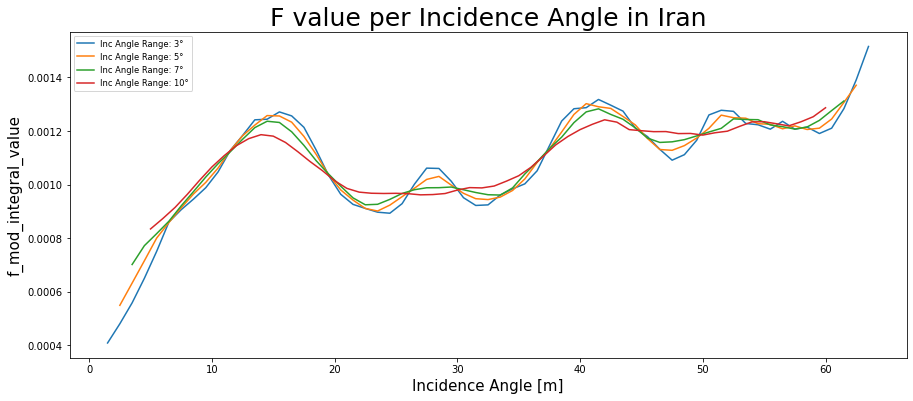

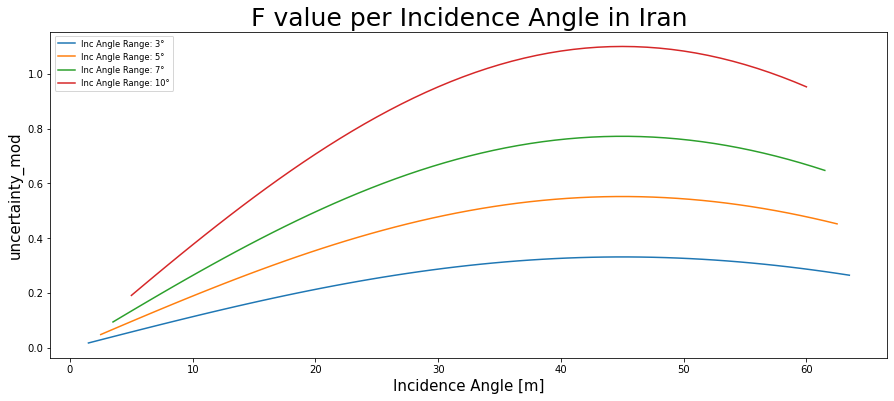

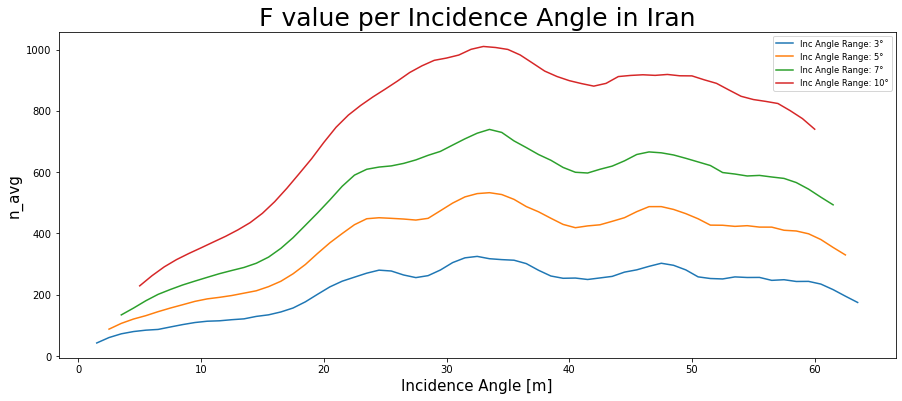

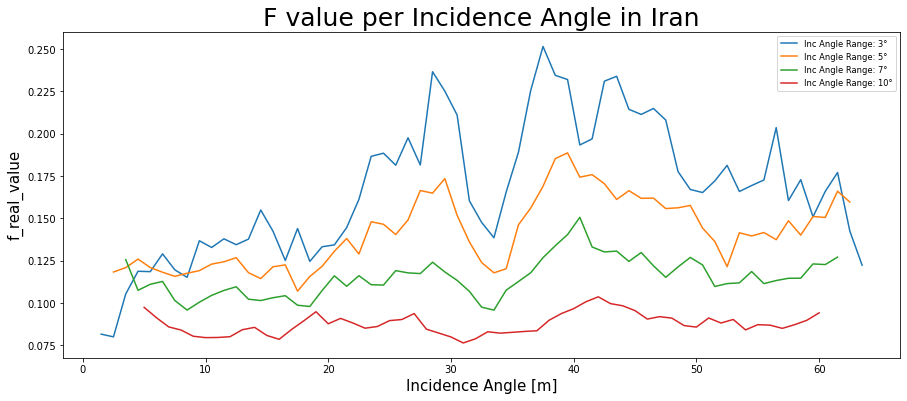

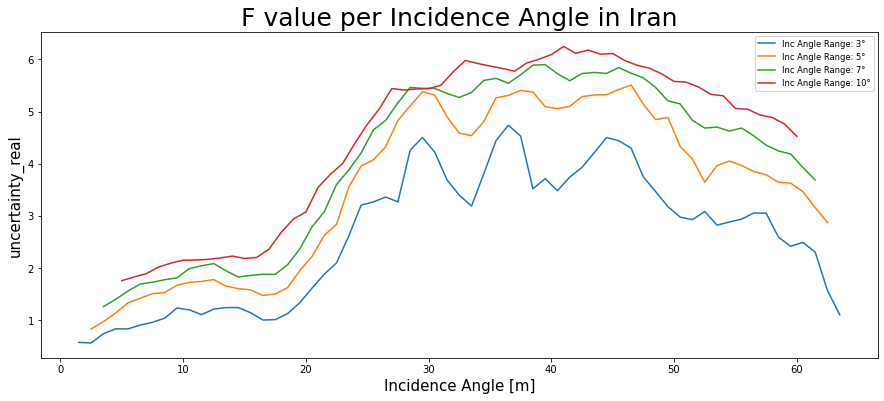

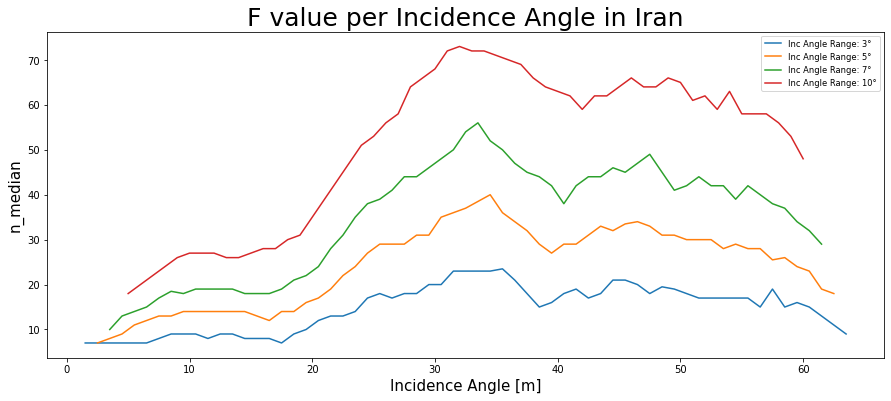

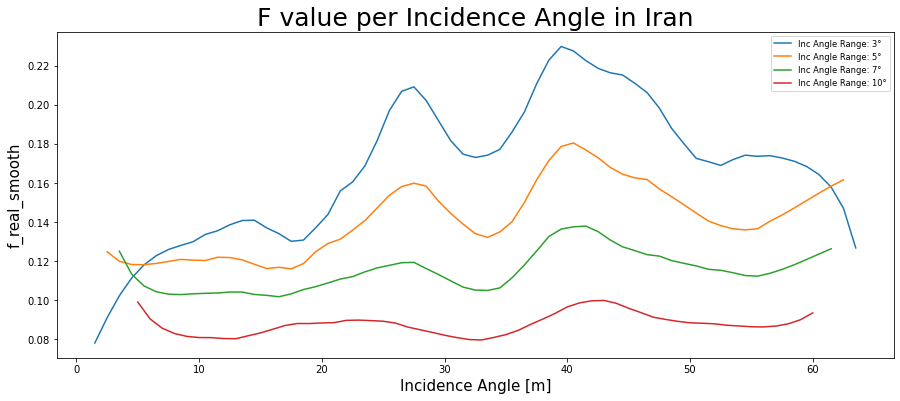

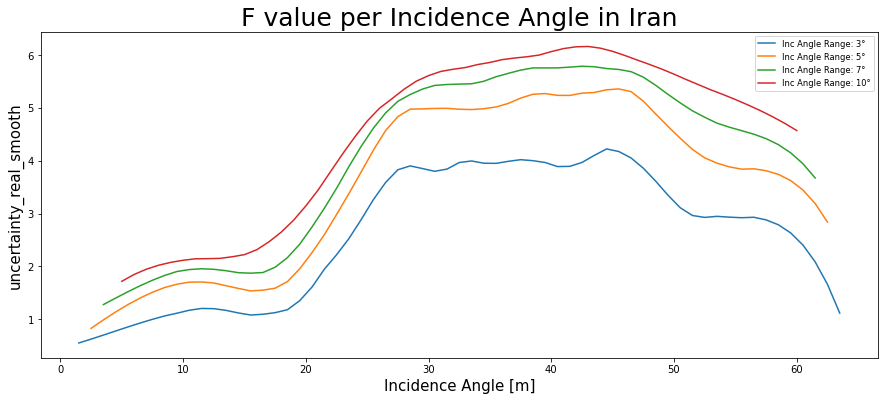

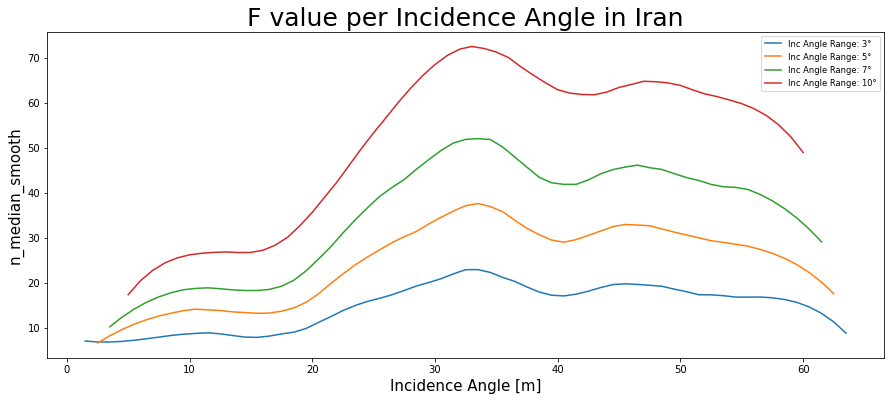

In [62]:
params2plot = ['f_mod_integral_value', 'uncertainty_mod', 'n_avg', 'f_real_value', 'uncertainty_real', 'n_median', 'f_real_smooth', 'uncertainty_real_smooth', 'n_median_smooth']

if choose_single_area:
    area_df = full_df[full_df['area'] == single_area]
    for param in params2plot:
            plot_param_vs_inc_angle(area_df, param, single_area)
else:
    for area in locations_df['area']:
        area_df = full_df[full_df['area'] == area]
        for param in params2plot:
            plot_param_vs_inc_angle(area_df, param, area)
            

### Plot Median Standard Deviation in an Area

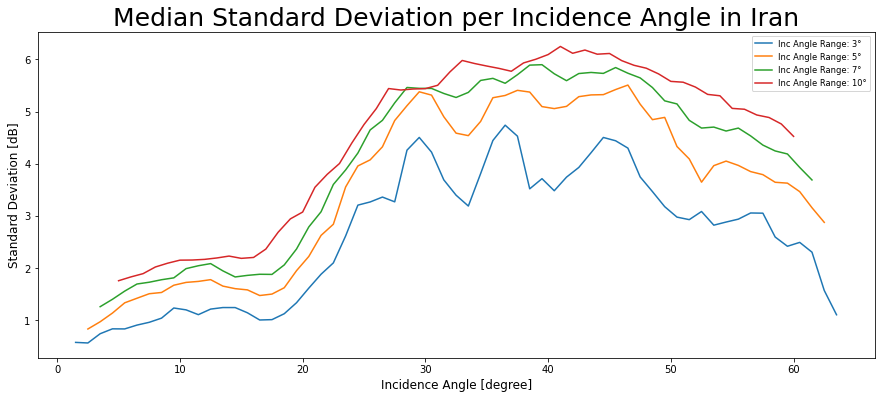

In [56]:
fig = plt.figure(figsize=(15, 6))
ranges = sr_sd_df['inc_range'].unique()

for inc_range in ranges:
    angles = []
    sd_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        sd_values = sr_sd_df[sr_sd_df['inc_range'] == inc_range]
        sd_values = list(sd_values['sr_sd'][sd_values['inc_start'] == x_0])
        sd_median = np.median(sd_values)
        
        angles.append(x_0 + inc_range/2)
        sd_median_values.append(sd_median)

    plt.plot(angles, sd_median_values, label='Inc Angle Range: ' + str(inc_range) + '°')
    # plt.title('Median Standard Deviation per Incidence Angle in ' + single_area, fontsize=18)
    plt.title('Median Standard Deviation per Incidence Angle in Iran', fontsize=25)
    plt.ylabel('Standard Deviation [dB]', fontsize=12)
    plt.xlabel('Incidence Angle [degree]', fontsize=12)

plt.legend(fontsize='small')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/' + parameter + 'AgainstIncAngle_' + area + '.png', bbox_inches='tight')
plt.show()


### Plot a Smoothened Median Standard Deviation in an Area

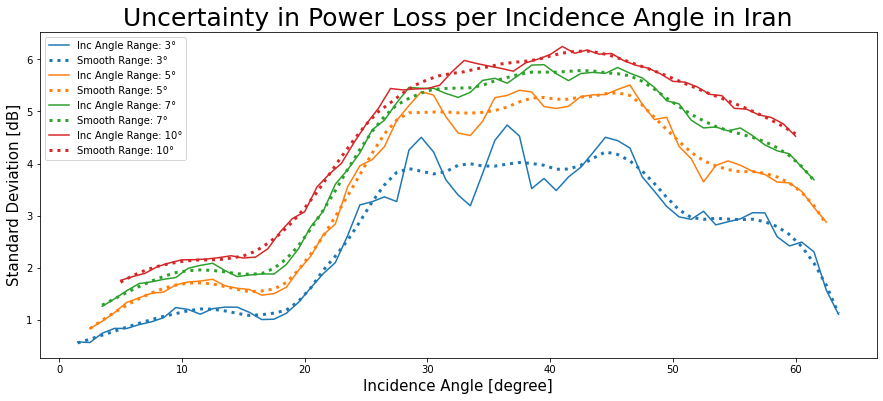

In [59]:
from scipy.signal import savgol_filter

colors = ['C0', 'C1', 'C2', 'C3']
color_count = 0

fig = plt.figure(figsize=(15, 6))
ranges = sr_sd_df['inc_range'].unique()

for inc_range in ranges:
    angles = []
    sd_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        sd_values = sr_sd_df[sr_sd_df['inc_range'] == inc_range]
        sd_values = list(sd_values['sr_sd'][sd_values['inc_start'] == x_0])
        sd_median = np.median(sd_values)
        
        angles.append(x_0 + inc_range/2)
        sd_median_values.append(sd_median)
    
    sd_median_smooth = savgol_filter(sd_median_values, 13, 3)
    
    plt.plot(angles, sd_median_values, label='Inc Angle Range: ' + str(inc_range) + '°', color = colors[color_count])
    plt.plot(angles, sd_median_smooth, linestyle = 'dotted', linewidth=3, color = colors[color_count], label = 'Smooth Range: ' + str(inc_range) + '°')
    # plt.title('Median Standard Deviation per Incidence Angle in ' + area, fontsize=25)
    # plt.title('Median Standard Deviation per Incidence Angle in Iran', fontsize=25)
    plt.title('Uncertainty in Power Loss per Incidence Angle in Iran', fontsize=25)
    plt.ylabel('Standard Deviation [dB]', fontsize=15)
    plt.xlabel('Incidence Angle [degree]', fontsize=15)
    color_count += 1

plt.legend(fontsize='medium')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/' + parameter + 'AgainstIncAngle_' + area + '.png', bbox_inches='tight')
# plt.savefig('/Users/madsrindal/Desktop/MeanSDAgainstIncAngle_Iran.png', bbox_inches='tight')
plt.show()


In [ ]:
from scipy.signal import savgol_filter

colors = ['C0', 'C1', 'C2', 'C3']
color_count = 0

fig = plt.figure(figsize=(15, 6))
ranges = sr_sd_df['inc_range'].unique()

for inc_range in ranges:
    angles = []
    n_median_values = []
    
    for x_0 in range(0, (56+(10-inc_range))):
        
        df = sr_sd_df[sr_sd_df['inc_range'] == inc_range]
        n_obs_values = list(df['n_obs'][df['inc_start'] == x_0])
        n_median = np.median(n_obs_values)
        
        angles.append(x_0 + inc_range/2)
        n_median_values.append(n_median)
    
    n_median_smooth = savgol_filter(n_median_values, 13, 3)
    
    plt.plot(angles, n_median_values, label='Inc Angle Range: ' + str(inc_range) + '°', color = colors[color_count])
    plt.plot(angles, n_median_smooth, linestyle = 'dotted', linewidth=3, color = colors[color_count], label = 'Smooth Range: ' + str(inc_range) + '°')
    
    # plt.title('Median Number of Observations per Incidence Angle in ' + area, fontsize=25)
    plt.title('Median Number of Observations per Incidence Angle in Iran', fontsize=25)
    plt.ylabel('Observations', fontsize=15)
    plt.xlabel('Incidence Angle [degree]', fontsize=15)
    color_count += 1

plt.legend(fontsize='medium')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/' + parameter + 'AgainstIncAngle_' + area + '.png', bbox_inches='tight')
# plt.savefig('/Users/madsrindal/Desktop/MedianObsAgainstIncAngle_Congo.png', bbox_inches='tight')
plt.show()


### Plot Median Standard Deviation in Smaller Parts of an Area

In [ ]:
mean_box_size = 1

ranges = sr_sd_df['inc_range'].unique()

max_lat = round(sr_sd_df['north'].max())
min_lat = max_lat - mean_box_size

min_lon = round(sr_sd_df['west'].min())
max_lon = min_lon + mean_box_size
        
for lat in range(max_lat, max_lat-1 - (5-mean_box_size), -1):
    for lon in range(min_lon, min_lon+1 + (5-mean_box_size), 1):
        filtered_sr_sd_df_box = sr_sd_df[sr_sd_df['north'] <= lat]
        filtered_sr_sd_df_box = filtered_sr_sd_df_box[filtered_sr_sd_df_box['west'] >= lon]
        filtered_sr_sd_df_box = filtered_sr_sd_df_box[filtered_sr_sd_df_box['south'] >= lat-mean_box_size]
        filtered_sr_sd_df_box = filtered_sr_sd_df_box[filtered_sr_sd_df_box['east'] <= lon+mean_box_size]
        
        center_point_lat = lat + mean_box_size/2
        center_point_lon = lon + mean_box_size/2
        
        center_point = '(' + str(center_point_lat) + ', ' + str(center_point_lon) + ')'
        
        colors = ['C0', 'C1', 'C2', 'C3']
        color_count = 0
        fig = plt.figure(figsize=(15, 6))

        for inc_range in ranges:
            angles = []
            sd_median_values = []

            for x_0 in range(0, (56+(10-inc_range))):

                sd_values = filtered_sr_sd_df_box[filtered_sr_sd_df_box['inc_range'] == inc_range]
                sd_values = list(sd_values['sr_sd'][sd_values['inc_start'] == x_0])
                sd_median = np.median(sd_values)

                angles.append(x_0 + inc_range/2)
                sd_median_values.append(sd_median)
            
            try:
                sd_median_smooth = savgol_filter(sd_median_values, 13, 3)
                #plt.plot(angles, sd_median_smooth, linestyle = 'dotted', linewidth=3, color = colors[color_count])
            except:
                print('Could not smooth the values...')
            
            plt.plot(angles, sd_median_values, color = colors[color_count])


            plt.title('Median Standard Deviation per Incidence Angle in ' + area + ' at ' + center_point, fontsize=18)
            plt.ylabel('Standard Deviation [dB]', fontsize=12)
            plt.xlabel('Incidence Angle [degree]', fontsize=12)
            color_count += 1

        # plt.savefig('/Users/madsrindal/Desktop/Master Plots/' + parameter + 'AgainstIncAngle_' + area + '.png', bbox_inches='tight')
        plt.show()


### TESTING

In [ ]:
for i in range(20, 40):
    print('Incidence angle: ', i)
    print('Median Standard Deviation Real: ', get_pl_from_inc_angle(sr_sd_df, i, 3))
    print('Median Standard Deviation Smooth: ', get_pl_smooth_from_inc_angle(sr_sd_df, i, 3))
    print('\n')